In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf

In [2]:
IMG_SIZE  = 16
 

# load data 

In [3]:
img_path = Path("data/images").resolve()
label_path = Path("data/labels").resolve()
img_path = img_path.glob("*.png")
label_path = label_path.glob("*.json")

X = []
Y = []
for img, label in zip(img_path, label_path):
    X.append(plt.imread(img))
    Y.append(np.array(pd.read_json(label)))
X = np.array(X)
Y = np.array(Y)
print(Y.shape)

(292, 1, 4)


*we added black players just to make task harder for model*

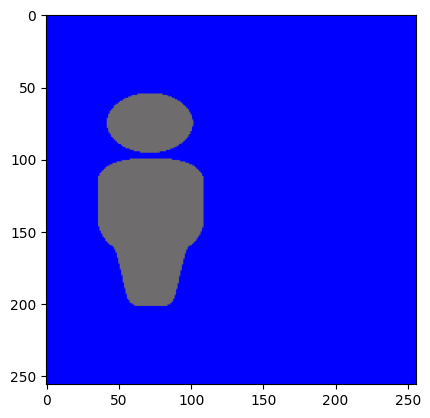

In [4]:
plt.imshow(X[0])

## prepare data
1. resizes images to SIZExSIZE
2. normalizes images to [0,1]

In [5]:
X = [cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in X] 
# greyscale
X = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X]
X = np.array(X)
# normalize
X = X / 255.0



print(X.shape, Y.shape)

(292, 16, 16) (292, 1, 4)


[[0.2578125 0.21875   0.2890625 0.578125 ]]
[[0.19140625 0.08203125 0.2890625  0.578125  ]]
[[0.23046875 0.375      0.2890625  0.578125  ]]
[[0.3984375 0.046875  0.2890625 0.578125 ]]
[[0.6171875  0.25390625 0.2890625  0.578125  ]]
[[0.015625   0.18359375 0.2890625  0.578125  ]]


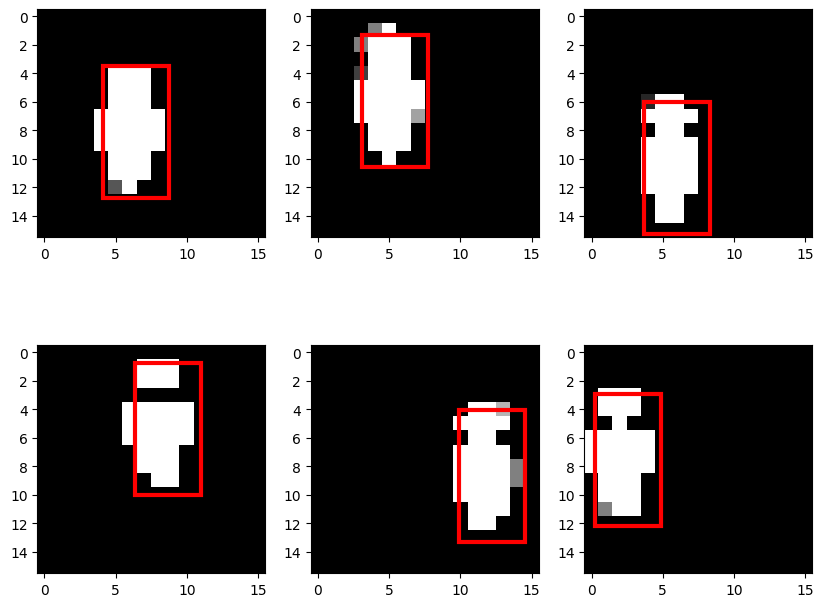

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(10, 8))
images = np.random.choice(X.shape[0], 6)

for i in range(2):
    for j in range(3):
        rect = Y[images[i * 3 + j]]
        print(rect)
        for r in rect:
            x, y, w, h = r
            ax[i, j].add_patch(
                plt.Rectangle(
                    (x * IMG_SIZE, y * IMG_SIZE),
                    w * IMG_SIZE,
                    h * IMG_SIZE,
                    fill=False,
                    edgecolor="red",
                    lw=3,
                )
            )
        ax[i, j].imshow(X[images[i * 3 + j]], cmap="gray")

plt.show()


In [7]:
# split data into train and test
X = X.reshape(X.shape[0], IMG_SIZE, IMG_SIZE ,1)

Y = Y.reshape(Y.shape[0], Y.shape[1] * 4)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape,  X_test.shape, y_train.shape, y_test.shape)


(233, 16, 16, 1) (59, 16, 16, 1) (233, 4) (59, 4)


In [8]:
path = Path("data").resolve()
np.save(path / "X_train.npy", X_train)
np.save(path / "X_test.npy", X_test)
np.save(path / "y_train.npy", y_train)
np.save(path / "y_test.npy", y_test)
